In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pointbiserialr, chi2_contingency
# import pingouin as pg

In [2]:
# 1. Loading data
df = pd.read_csv("./data/Input_data.csv")

# 1.1 Cleaning data
# Elimination of the least informative variables
cols_to_drop = ['property_ID','locality_name','postal_code','type','subtype','open_fire','terrace_area','number_facades','price_per_m2','province','region']
df = df.drop(columns=cols_to_drop)
# df = df[df['price'] < 1000000] - для отфильтровки элитной недвижимости (2,4%)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14547 entries, 0 to 14546
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   property_type       14545 non-null  object 
 1   price               14546 non-null  float64
 2   number_of_bedrooms  14397 non-null  float64
 3   living_area         14545 non-null  float64
 4   equiped_kitchen     14545 non-null  float64
 5   furnished           14545 non-null  float64
 6   terrace             14545 non-null  float64
 7   garden              14545 non-null  float64
 8   swimming_pool       14545 non-null  float64
 9   state_of_building   11632 non-null  object 
 10  municipality        14545 non-null  object 
dtypes: float64(8), object(3)
memory usage: 1.2+ MB


In [3]:
# 2. Defining column types
def detect_column_type(series, cat_threshold=15):
    if pd.api.types.is_numeric_dtype(series):
        if series.nunique() == 2:
            return "binary"
        else:
            return "numerical"
    else:
        if series.nunique() == 2:
            return "binary"
        elif series.nunique() <= cat_threshold:
            return "categorical"
        else:
            return "categorical"

column_types = {col: detect_column_type(df[col]) for col in df.columns}
print("\nColumn types:")
for col, tp in column_types.items():
    print(f"{col}: {tp}")


Column types:
property_type: categorical
price: numerical
number_of_bedrooms: numerical
living_area: numerical
equiped_kitchen: binary
furnished: binary
terrace: binary
garden: binary
swimming_pool: binary
state_of_building: categorical
municipality: categorical


In [4]:
# 3. Functions for calculating correlation
# Eta_squared: Numerical vs Categorical
def encode_binary(series):
    if series.nunique() != 2:
        return series
    classes = list(series.unique())
    mapping = {classes[0]: 0, classes[1]: 1}
    return series.map(mapping)

""" def eta_squared(df, numerical, categorical):
    groups = df.groupby(categorical)[numerical]
    ss_between = sum([len(g) * (g.mean() - df[numerical].mean())**2 for name, g in groups])
    ss_total = sum((df[numerical] - df[numerical].mean())**2)
    return ss_between / ss_total if ss_total != 0 else 0"""
def eta_squared(df, categorical, numerical):
    data = df[[categorical, numerical]].dropna()
    # если нет данных — нет связи
    if data.empty:
        return np.nan
    # если категория одна — дисперсия между группами 0
    if data[categorical].nunique() < 2:
        return 0.0
    overall_mean = data[numerical].mean()

    ss_between = 0
    for cat, g in data.groupby(categorical):
        if g[numerical].count() == 0:
            continue
        ss_between += len(g) * (g[numerical].mean() - overall_mean) ** 2

    ss_total = ((data[numerical] - overall_mean) ** 2).sum()

    if ss_total == 0:
        return 0.0
    return ss_between / ss_total

# Сramers_v: Categorical vs Binary
def cramers_v(x, y):
    contingency = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency)
    n = contingency.sum().sum()
    r, k = contingency.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# phi_coefficient: Binary vs Binary
def phi_coefficient(x, y):
    contingency = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency)
    n = contingency.to_numpy().sum()
    return np.sqrt(chi2 / n)

# Spearman: Numerical vs Numerical
def safe_spearman(a, b):
    a_num = pd.to_numeric(a, errors='coerce')
    b_num = pd.to_numeric(b, errors='coerce')
    mask = a_num.notna() & b_num.notna()
    if mask.sum() < 3:
        return np.nan
    val, _ = spearmanr(a_num[mask], b_num[mask])
    return val

# Point-Biserial: Numerical vs Binary
def safe_pointbiserial(numeric, binary):
    numeric = pd.to_numeric(numeric, errors='coerce')
    binary = pd.to_numeric(binary, errors='coerce')
    mask = numeric.notna() & binary.notna()
    if mask.sum() < 3:
        return np.nan
    try:
        val, _ = pointbiserialr(numeric[mask], binary[mask])
        return val
    except Exception:
        return np.nan

In [5]:
# 4. Construction of a “mixed correlation matrix”qq
def correlation_value(x, y, type_x, type_y):
    try:
        # numerical-numerical
        if type_x == "numerical" and type_y == "numerical":
            return safe_spearman(x, y)

        # numerical-binary
        if type_x == "binary" and type_y == "numerical":
            return safe_pointbiserial(encode_binary(x), y)

        if type_x == "numerical" and type_y == "binary":
            return safe_pointbiserial(x, encode_binary(y))

        # numerical-categorical
        if type_x == "numerical" and type_y == "categorical":
            return eta_squared(df, y.name, x.name)

        if type_x == "categorical" and type_y == "numerical":
            return eta_squared(df, x.name, y.name)

        # binary-binary
        if type_x == "binary" and type_y == "binary":
            return phi_coefficient(x, y)

        # categorical-categorical
        if type_x == "categorical" and type_y == "categorical":
            return cramers_v(x, y)

        # categorical-categorical
        if type_x == "categorical" and type_y == "binary":
            return cramers_v(x, encode_binary(y))
        if type_x == "binary" and type_y == "categorical":
            return cramers_v(encode_binary(x), y)

    except Exception:
        return np.nan

    return np.nan

columns = df.columns
corr_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

for col1 in columns:
    for col2 in columns:
        t1 = column_types[col1]
        t2 = column_types[col2]
        corr_matrix.loc[col1, col2] = correlation_value(df[col1], df[col2], t1, t2)

# ensure numeric values; coerce errors to NaN
corr_matrix = corr_matrix.apply(pd.to_numeric, errors='coerce')

print("Mixed correlation matrix:")
print(corr_matrix) 

Mixed correlation matrix:
                    property_type     price  number_of_bedrooms  living_area  \
property_type            1.000000  0.116573            0.334591     0.309030   
price                    0.116573  1.000000            0.486347     0.588492   
number_of_bedrooms       0.334591  0.486347            1.000000     0.838717   
living_area              0.309030  0.588492            0.838717     1.000000   
equiped_kitchen          0.114054  0.138141            0.046960     0.050426   
furnished                0.225611  0.014839            0.046160     0.015567   
terrace                  0.248722 -0.124780            0.045383     0.035247   
garden                   0.595222  0.180922            0.329511     0.297362   
swimming_pool            0.205770  0.252684            0.146345     0.227222   
state_of_building        0.187312  0.044827            0.086872     0.082410   
municipality             0.316026  0.263875            0.162153     0.167464   

             

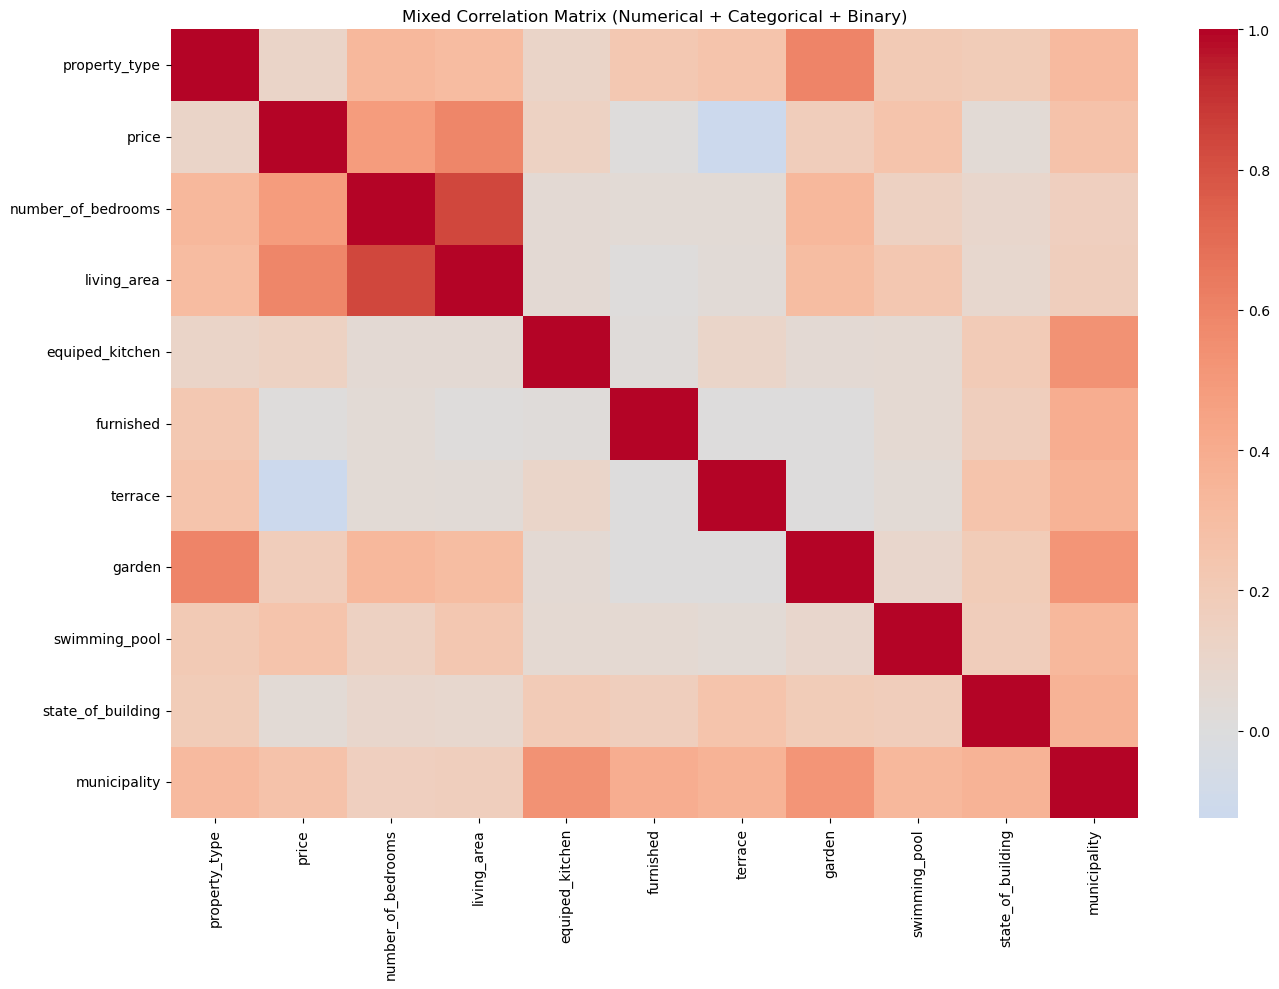

In [6]:
# 5. Visualization of a mixed matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix.astype(float), annot=False, cmap="coolwarm", center=0)
plt.title("Mixed Correlation Matrix (Numerical + Categorical + Binary)")
plt.tight_layout()
plt.show()

In [7]:
# 6. Top 5 Strongest Relationships
# Convert the matrix to long format
corr_long = (
    corr_matrix.stack()
    .reset_index()
)
corr_long.columns = ["col1", "col2", "corr"]

# We remove pairs with ourselves
corr_long = corr_long[corr_long["col1"] != corr_long["col2"]]

# Remove duplication (A,B) and (B,A)
corr_long["pair"] = corr_long.apply(lambda row: tuple(sorted([row["col1"], row["col2"]])), axis=1)
corr_long = corr_long.drop_duplicates(subset="pair")

# Sort by connection strength (by modulus)
corr_long["abs_corr"] = corr_long["corr"].abs()
top5 = corr_long.sort_values("abs_corr", ascending=False).head(5)

print("\nTOP 5 strongest connections:")
print(top5[["col1", "col2", "corr"]])


TOP 5 strongest connections:
                  col1          col2      corr
25  number_of_bedrooms   living_area  0.838717
7        property_type        garden  0.595222
14               price   living_area  0.588492
54     equiped_kitchen  municipality  0.531047
87              garden  municipality  0.518738



🔍 Visualization of the TOP-5 strongest connections:

▶ number_of_bedrooms ↔ living_area  (type: numerical–numerical), corr=0.839


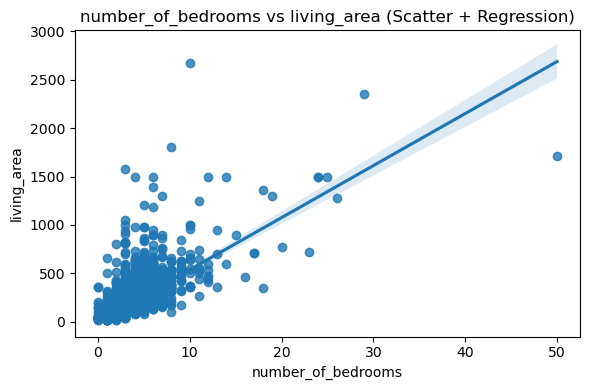

▶ property_type ↔ garden  (type: categorical–binary), corr=0.595


<Figure size 600x400 with 0 Axes>

▶ price ↔ living_area  (type: numerical–numerical), corr=0.588


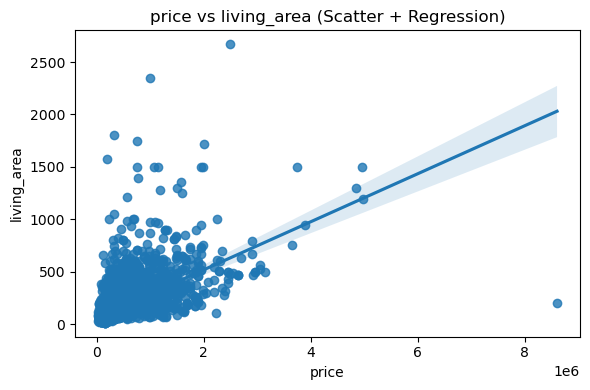

▶ equiped_kitchen ↔ municipality  (type: binary–categorical), corr=0.531


<Figure size 600x400 with 0 Axes>

▶ garden ↔ municipality  (type: binary–categorical), corr=0.519


<Figure size 600x400 with 0 Axes>

In [8]:
# 7. Visualization of the TOP-5 strongest connections

def plot_pair(df, col1, col2, type1, type2):
    # Builds the correct visualization depending on the types of the two columns.

    plt.figure(figsize=(6, 4))

    # Numerical ↔ Numerical
    if type1 == "numerical" and type2 == "numerical":
        sns.regplot(x=col1, y=col2, data=df)
        plt.title(f"{col1} vs {col2} (Scatter + Regression)")

    # Numerical ↔ Binary
    elif (type1 == "numerical" and type2 == "binary") or (type1 == "binary" and type2 == "numerical"):
        if type1 == "numerical":
            sns.boxplot(x=col2, y=col1, data=df)
            plt.title(f"{col1} ~ {col2} (Boxplot)")
        else:
            sns.boxplot(x=col1, y=col2, data=df)
            plt.title(f"{col2} ~ {col1} (Boxplot)")

    # Numerical ↔ Categorical
    elif (type1 == "numerical" and type2 == "categorical") or (type1 == "categorical" and type2 == "numerical"):
        if type1 == "numerical":
            sns.boxplot(x=col2, y=col1, data=df)
            plt.title(f"{col1} ~ {col2} (Boxplot)")
        else:
            sns.boxplot(x=col1, y=col2, data=df)
            plt.title(f"{col2} ~ {col1} (Boxplot)")

    # Binary ↔ Binary
    elif type1 == "binary" and type2 == "binary":
        contingency = pd.crosstab(df[col1], df[col2])
        sns.heatmap(contingency, annot=True, fmt="d")
        plt.title(f"{col1} vs {col2} (2×2 Heatmap)")

    # Categorical ↔ Categorical
    elif type1 == "categorical" and type2 == "categorical":
        contingency = pd.crosstab(df[col1], df[col2])
        sns.heatmap(contingency, annot=True, fmt="d")
        plt.title(f"{col1} vs {col2} (Categorical Heatmap)")

    plt.tight_layout()
    plt.show()


print("\n🔍 Visualization of the TOP-5 strongest connections:\n")

for _, row in top5.iterrows():
    col1, col2 = row["col1"], row["col2"]
    type1 = column_types[col1]
    type2 = column_types[col2]

    print(f"▶ {col1} ↔ {col2}  (type: {type1}–{type2}), corr={row['corr']:.3f}")
    plot_pair(df, col1, col2, type1, type2)